# Radiomics analysis

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import fastcluster
import json
import itertools

from scipy import stats
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.multitest import fdrcorrection, multipletests
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from tqdm import tqdm
from tools_analysis import auc_and_f1

ds_path = "../study/stats/datasetRadiomics.csv"

In [3]:
df = pd.read_csv(ds_path, index_col="ID")
df.shape

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

[roi_name]\_[metric]\_[image]\_[feature] 

In [5]:
def separateDFs(df, which="resp"):
    y1 = df[which]
    X = df.drop(["resp", "respPart"], axis=1)
    print(X.shape)

    a = X.isna().any(axis=0)
    # X1 is the first ds
    X1 = X.drop(a[a==True].index, axis=1)

    print(X1.shape)

    X2_1 = X.loc[:, a==True].drop("VNSLC_16")
    b = X2_1.isna().any(axis=0)
    # X2 is the second ds
    X2 = X2_1.drop(b[b==True].index, axis=1)
    y2 = y1.drop("VNSLC_16")
    print(X2.shape)

    # X3 is the third ds
    X3 = X2_1.loc[:, b==True].drop("VNSLC_19")
    y3 = y2.drop("VNSLC_19")
    print(X3.shape)

    return X1, y1, X2, y2, X3, y3

# Filtering

##### Remove duplicate

In [479]:
df_duplicates = df.T.drop_duplicates().T
df_duplicates.shape

(19, 786187)

##### Variance threshold

In [480]:
X1, y1, X2, y2, X3, y3 = separateDFs(df_duplicates)

(19, 786185)
(19, 464538)
(18, 307624)
(17, 14023)


In [481]:
X_selected = []

for X in [X1, X2, X3]:
    varThresh = VarianceThreshold()
    varThresh.fit_transform(X)
    selected_feature_indices = varThresh.get_support(indices=True)
    X_selected.append(X.iloc[:, selected_feature_indices])

df_selected = pd.concat([df["resp"], df["respPart"], X_selected[0], X_selected[1], X_selected[2]], axis=1)
df_selected.shape

(19, 786135)

##### Mannwhiten

In [482]:
X_resp = df_selected[df["resp"]==1]
X_non = df_selected[df["resp"]==0]
res_mannwhitneyu = pd.DataFrame(stats.mannwhitneyu(X_resp, X_non, nan_policy="omit").pvalue, index=df_selected.columns)

In [483]:
temp = res_mannwhitneyu>0.05
features_to_remove = temp[temp == True].dropna().index
df_mannwhiten = df_selected.drop(features_to_remove,axis=1)
df_mannwhiten.shape

(19, 38650)

##### Kruskal

In [484]:
X_resp= df_mannwhiten[df["respPart"]==2]
X_respPart = df_mannwhiten[df["respPart"]==1]
X_non = df_mannwhiten[df["respPart"]==0]
res_kruskal = pd.DataFrame(stats.kruskal(X_non, X_respPart, X_resp, nan_policy="omit", axis=0).pvalue, index=df_mannwhiten.columns)

In [485]:
temp = res_kruskal>0.05
features_to_remove = temp[temp == True].dropna().index
df_kruskal = df_mannwhiten.drop(features_to_remove,axis=1)
df_kruskal.shape

(19, 18288)

##### Outlier removal

In [486]:
features_to_remove = []

for i in [0, 1, 2]:
    df_curr = df_kruskal[df["respPart"]==i]
    z_scores_abs = abs((df_curr - df_curr.mean())/df_curr.std())

    features_with_outliers = (z_scores_abs >= 2).any(axis=0)
    features_to_remove_curr = features_with_outliers[features_with_outliers == True].dropna().index

    features_to_remove = [*features_to_remove, *features_to_remove_curr]

df_outliers = df_kruskal.drop(features_to_remove, axis=1)
df_outliers.shape

(19, 10566)

##### Kurtosis filtering

In [487]:
res_kurtosis = pd.DataFrame(stats.kurtosis(df_outliers, axis=0, bias=False, nan_policy="omit"), index=df_outliers.columns)
temp = (res_kurtosis>2) | (res_kurtosis<-0.5)
features_to_remove = temp[temp == True].dropna().index
df_kurtosis = df_outliers.drop(features_to_remove,axis=1)
df_kurtosis = pd.concat([df[["resp", "respPart"]], df_kurtosis], axis=1)
df_kurtosis.shape

(19, 5709)

##### Remove redundant

In [494]:
corr_matrix = df_kurtosis.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype("bool"))

to_drop = [column for column in upper.columns if any(upper[column]>=0.99)]
print(len(to_drop))

df_redundant = df_kurtosis.drop(to_drop, axis=1)
df_redundant.shape


1593


(19, 4116)

In [495]:
c = 0
correlated_features = []
for column in tqdm(upper.columns):
    temp = upper[column].isna() == False
    temp = temp[temp==True].index
    to_remove=False
    for col in temp:
        if upper[column][col]>=0.99:
            to_remove=True
            correlated_features.append((column, col, upper[column][col]))
    if to_remove:
        c += 1

correlated_features_df = pd.DataFrame(correlated_features)
print(c)

100%|██████████| 5709/5709 [01:47<00:00, 53.32it/s] 

1593


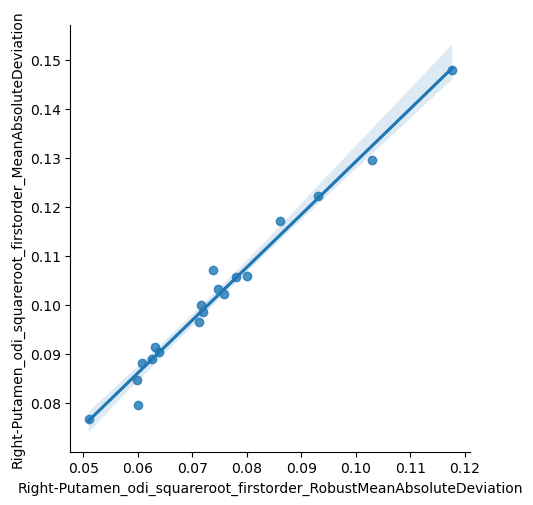

In [496]:
sns.lmplot(df_duplicates, x="Right-Putamen_odi_squareroot_firstorder_RobustMeanAbsoluteDeviation", y="Right-Putamen_odi_squareroot_firstorder_MeanAbsoluteDeviation")

In [503]:
df_redundant.to_csv("../study/stats/datasetRadiomicsFiltered.csv")

In [6]:
df_redundant = pd.read_csv("../study/stats/datasetRadiomicsFiltered.csv", index_col="ID")
df_redundant.shape

(19, 4116)

# Clustering

In [505]:
roi_name = [
    "Thalamus",
    "Hippocampus",
    "Amygdala",
    "Accumbens-area",
    "Putamen", 
    "Pallidum",
    "Caudate",
]

tract_name = [
    "acomm",
    "cc.bodyc",
    "cc.bodyp",
    "cc.bodypf",
    "cc.bodypm",
    "cc.bodyt",
    "cc.genu",
    "cc.rostrum",
    "cc.splenium",
    "lh.af",
    "lh.ar",
    "lh.atr",
    "lh.cbd",
    "lh.cbv",
    "lh.cst",
    "lh.emc",
    "lh.fat",
    "lh.fx",
    "lh.ilf",
    "lh.mlf",
    "lh.or",
    "lh.slf1",
    "lh.slf2",
    "lh.slf3",
    "lh.uf",
    "mcp",
    "lh.af",
    "rh.ar",
    "rh.atr",
    "rh.cbd",
    "rh.cbv",
    "rh.cst",
    "rh.emc",
    "rh.fat",
    "rh.fx",
    "rh.ilf",
    "rh.mlf",
    "rh.or",
    "rh.slf1",
    "rh.slf2",
    "rh.slf3",
    "rh.uf",
    "mcp"
]

In [506]:
def getDF(df, feature):
    df.drop(["resp", "respPart"], axis=1)
    df_filtered = df.filter(regex=feature)
    areNaN = df_filtered.isna().any(axis=1)
    to_remove = areNaN[areNaN == True].index
    return df_filtered.drop(to_remove), to_remove

In [507]:
lut = dict(zip([0, 1, 2], "ryg"))
row_colors = df_redundant["respPart"].map(lut)

image_types = {
    "original"      : "blue",
    "exponential"   : "orange",
    "gradient"      : "green",
    "lbp-2D"        : "red",
    "lbp-3D"        : "purple",
    "log"           : "brown",
    "logarithm"     : "pink",
    "square"        : "gray",
    "squareroot"    : "olive",
    "wavelet"       : "cyan"
}

def mapping_func(v):
    for image_type in lut.keys():
        if image_type in v:
            return lut[image_type]
    return "k"

lut = image_types
col_colors_image = pd.DataFrame(df_redundant.columns.map(mapping_func)).T
col_colors_image.columns = df_redundant.columns
col_colors_image = col_colors_image

metrics = {
    "FA"    : "red",
    "AD"    : "red",
    "RD"    : "red",
    "MD"    : "red",
    "icvf"  : "blue",
    "odi"   : "blue",
    "fextra": "blue",
    "fiso"  : "blue" ,
    "wFA"   : "yellow",
    "wMD"   : "yellow",
    "wAD"   : "yellow",
    "wRD"   : "yellow",
    "frac_csf": "green",
    "wfvf"  : "green",
    "fvf_tot": "green",
    "frac_csf":"green",
}

lut = metrics
col_colors_metrics = pd.DataFrame(df_redundant.columns.map(mapping_func)).T
col_colors_metrics.columns = df_redundant.columns
col_colors_metrics = col_colors_metrics

col_colors = pd.concat([col_colors_image, col_colors_metrics], axis=0, ignore_index=True)
col_colors.index = ["image_type", "model_type"]

In [508]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/roi/"):
    os.mkdir(f"../imgs/clustering/roi/")

if not os.path.isdir(f"../imgs/clustering/roi/{method}/"):
    os.mkdir(f"../imgs/clustering/roi/{method}/")

for mask in roi_name:
    for side in ["Left", "Right"]:
        # print(side, mask)

        regex = f"{side}-{mask}"
        df, to_remove = getDF(df_redundant, regex)
        col_colors_filtered = col_colors.filter(regex=regex).T

        sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, xticklabels=False)
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask}-{side}-{method}.png")

        del df
        del col_colors_filtered
        plt.close()

for mask in tract_name:
    # print(mask)

    regex = f"{mask}"
    df, to_remove = getDF(df_redundant, regex)
    col_colors_filtered = col_colors.filter(regex=regex).T

    sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, xticklabels=False)
    mask_fields = mask.split(".")
    if len(mask_fields) == 1:
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask}-{method}.png")
    else:
        plt.savefig(f"../imgs/clustering/roi/{method}/{mask_fields[1]}-{mask_fields[0]}-{method}.png")

    del df
    del col_colors_filtered
    plt.close()

In [509]:
method = "average"

if not os.path.isdir(f"../imgs/clustering/metrics/"):
    os.mkdir(f"../imgs/clustering/metrics/")

if not os.path.isdir(f"../imgs/clustering/metrics/{method}/"):
    os.mkdir(f"../imgs/clustering/metrics/{method}/")

for metric in metrics.keys():
    regex = f"{metric}"
    df, to_remove = getDF(df_redundant, regex)
    col_colors_filtered = col_colors.filter(regex=regex).T

    sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, xticklabels=False)

    plt.savefig(f"../imgs/clustering/metrics/{method}/{metric}.png")
    
    del df
    del col_colors_filtered
    plt.close()

for image_type in image_types.keys():
    regex = f"{image_type}"
    df, to_remove = getDF(df_redundant, regex)
    col_colors_filtered = col_colors.filter(regex=regex).T

    sns.clustermap(df, row_colors=row_colors.drop(to_remove), col_colors=col_colors_filtered, z_score=1, method=method, robust=True, xticklabels=False)

    plt.savefig(f"../imgs/clustering/metrics/{method}/{image_type}.png")
    
    del df
    del col_colors_filtered
    plt.close()

# Score estimation with Cross Validation

In [77]:
def estimateScoresLogReg(X, y, pca=False, lda=False):
    isBinary = True if y.unique().size == 2 else False

    auc_str = "roc_auc" if isBinary else "roc_auc_ovr_weighted"
    f1_str = "f1" if isBinary else "f1_weighted"

    logReg = LogisticRegression(
        C=1e-6,
        class_weight="balanced",
        random_state=7,
        n_jobs=-1,
        max_iter=10000
    )

    pipe_dict = {
        "scaler": StandardScaler(),
        "pca": PCA(
            n_components=2,
            whiten=True,
            svd_solver="full",
            random_state=7
        ),
        "lda": LinearDiscriminantAnalysis(
            n_components=2
        ),
        "estimator": logReg,
    }

    if pca == False:
        del pipe_dict["pca"]

    if lda == False:
        del pipe_dict["lda"]

    cv = cross_validate(
        Pipeline(list(pipe_dict.items())),
        X, y,
        scoring=(auc_str, f1_str, "balanced_accuracy", "neg_brier_score", "neg_log_loss") if isBinary else (auc_str, f1_str, "balanced_accuracy", "neg_log_loss"),
        cv=3,
        n_jobs=-1,
    )

    approx_auc = cv[f"test_{auc_str}"].mean()
    approx_f1 = cv[f"test_{f1_str}"].mean()
    print("roc_auc + f1:\t%.3f\t(%.3f,\t%.3f)" % (approx_auc + approx_f1, approx_auc, approx_f1))

    approx_acc = cv["test_balanced_accuracy"].mean()
    print("accuracy:\t%.3f" % (approx_acc))

    if isBinary:
        print("Brier:\t\t%.3f" % cv["test_neg_brier_score"].mean())
    print("LogLoss:\t%.3f" % cv["test_neg_log_loss"].mean())


# Feature selection (Multivariate)

We are going to use a Recoursive Feature Selection to keep the just amount of features to correctly classify the output

In [8]:
def fitLinearSVM(X, y, C=1e-3, min_features_to_select=1):
    recursive_feature_elimination_svm = RFECV(
        Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(
                C=C,
                kernel="linear",
                class_weight="balanced",
            )),
        ]),
        min_features_to_select=min_features_to_select,
        cv=3,
        scoring=make_scorer(auc_and_f1, needs_threshold=True),
        n_jobs=-1,
        importance_getter="named_steps.svm.coef_" # Because of the pipe
    )
    recursive_feature_elimination_svm.fit(X, y)
    return recursive_feature_elimination_svm

def fitLogReg(X, y, C=1e-3, min_features_to_select=1):
    recursive_feature_elimination_logreg = RFECV(
        Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(
                C=C,
                class_weight="balanced",
                random_state=7,
                n_jobs=-1,
                max_iter=10000
            ))
        ]),
        min_features_to_select=min_features_to_select,
        cv=3,
        scoring=make_scorer(auc_and_f1, needs_proba=True),
        n_jobs=-1,
        importance_getter="named_steps.logreg.coef_" # Because of the pipe
    )

    recursive_feature_elimination_logreg.fit(X, y)
    return recursive_feature_elimination_logreg

def printScoresByFeature(rfecv, min, max, min_selected=1,):
    n_scores = len(rfecv.cv_results_["mean_test_score"][min:max])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_selected, n_scores + min_selected),
        rfecv.cv_results_["mean_test_score"][min:max],
        yerr=rfecv.cv_results_["std_test_score"][min:max],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

#### RFE

##### Multiclass

In [105]:
X1, y1, X2, y2, X3, y3 = separateDFs(df_redundant, "respPart")

estimateScoresLogReg(X1, y1)
estimateScoresLogReg(X2, y2)
estimateScoresLogReg(X3, y3)
print()
estimateScoresLogReg(df_redundant.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp", "respPart"], axis=1), y3)

X1, y1, X2, y2, X3, y3 = separateDFs(df_redundant, "respPart")

(19, 4114)
(19, 2394)
(18, 1673)
(17, 47)
roc_auc + f1:	1.845	(0.972,	0.873)
accuracy:	0.852
LogLoss:	-1.095
roc_auc + f1:	1.919	(0.975,	0.944)
accuracy:	0.944
LogLoss:	-1.096
roc_auc + f1:	1.734	(0.912,	0.822)
accuracy:	0.852
LogLoss:	-1.099

roc_auc + f1:	1.975	(0.975,	1.000)
accuracy:	1.000
LogLoss:	-1.093
(19, 4114)
(19, 2394)
(18, 1673)
(17, 47)


In [10]:
feature_selected = []

for X, y in [(X1, y1), (X2, y2), (X3, y3)]:
    recursive_feature_elimination_logreg = fitLogReg(X, y)

    logreg_selected = recursive_feature_elimination_logreg.get_feature_names_out()

    feature_selected = [*feature_selected, *logreg_selected]

df_multivariate_multiclass = df_redundant[feature_selected]
df_multivariate_multiclass = pd.concat([df_redundant[["resp", "respPart"]], df_multivariate_multiclass], axis=1)
df_multivariate_multiclass.shape

(19, 1006)

#### SFS

In [106]:
X1, y1, X2, y2, X3, y3 = separateDFs(df_multivariate_multiclass, "respPart")

estimateScoresLogReg(X1, y1)
estimateScoresLogReg(X2, y2)
estimateScoresLogReg(X3, y3)
print()
estimateScoresLogReg(df_multivariate_multiclass.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp", "respPart"], axis=1), y3)

(19, 1004)
(19, 425)
(18, 538)
(17, 41)
roc_auc + f1:	1.952	(1.000,	0.952)
accuracy:	0.963
LogLoss:	-1.098
roc_auc + f1:	2.000	(1.000,	1.000)
accuracy:	1.000
LogLoss:	-1.098
roc_auc + f1:	1.762	(0.940,	0.822)
accuracy:	0.852
LogLoss:	-1.099

roc_auc + f1:	2.000	(1.000,	1.000)
accuracy:	1.000
LogLoss:	-1.097


In [107]:
from contextlib import redirect_stdout, redirect_stderr, contextmanager, ExitStack
import os

@contextmanager
def suppress(out=True, err=False):
    with ExitStack() as stack:
        with open(os.devnull, "w") as null:
            if out:
                stack.enter_context(redirect_stdout(null))
            if err:
                stack.enter_context(redirect_stderr(null))
            yield

In [14]:
features_to_select = 10 + 1

logReg = LogisticRegression(
    C=1e-6,
    class_weight="balanced",
    random_state=7,
    n_jobs=-1,
    max_iter=10000
)

with suppress():
    X1, y1_bin, X2, y2_bin, X3, y3_bin = separateDFs(df_multivariate_multiclass, "resp")
    X1, y1_multi, X2, y2_multi, X3, y3_multi = separateDFs(df_multivariate_multiclass, "respPart")

selected_features = []

for X_full, y_bin, y_multi in [(X1, y1_bin, y1_multi), (X2, y2_bin, y2_multi), (X3, y3_bin, y3_multi)]:

    best_selected = []
    prev_best_score = 0

    for n_features in range(1, min(features_to_select, X_full.shape[1]+1)):

        scores = {}

        for col in X_full.columns:

            if col in best_selected:
                continue

            X = X_full[[*best_selected, col]]

            score = 0
            for isBinary in [True, False]:

                auc_str = "roc_auc" if isBinary else "roc_auc_ovr_weighted"
                f1_str = "f1" if isBinary else "f1_weighted"
                y = y_bin if isBinary else y_multi

                cv = cross_validate(
                    Pipeline([
                        ("scaler", StandardScaler()),
                        ("estimator", logReg),
                    ]),
                    X, y,
                    scoring=(auc_str, f1_str, "neg_brier_score", "neg_log_loss") if isBinary else (auc_str, f1_str, "neg_log_loss"),
                    cv=3,
                    n_jobs=-1,
                )

                score += cv[f"test_{auc_str}"].mean()
                score += cv[f"test_{f1_str}"].mean()
                if isBinary:
                    score += cv["test_neg_brier_score"].mean()
                    score += cv["test_neg_log_loss"].mean()
                else:
                    score += cv["test_neg_log_loss"].mean()

            scores[col] = score
        
        scores = pd.Series(scores)
        best_idx = scores.argmax()

        best_feature = scores.index[best_idx]
        best_score = scores[best_idx]

        # print(best_feature)
        # print(best_score)

        if abs(best_score-prev_best_score) < 1e-3:
            # print("Stopping...")
            # print()
            break
        prev_best_score = best_score

        best_selected.append(best_feature)

    selected_features = [*selected_features, *best_selected]

    # print(best_selected)
    # print()

df_sfs = df_multivariate_multiclass[selected_features]
df_sfs = pd.concat([df_multivariate_multiclass[["resp", "respPart"]], df_sfs], axis=1)
df_sfs.shape

  0%|          | 1/425 [00:00<01:01,  6.86it/s]

100%|██████████| 425/425 [00:46<00:00,  9.11it/s]
/tmp/ipykernel_4050605/1535259876.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_score = scores[best_idx]
100%|██████████| 425/425 [00:50<00:00,  8.42it/s]
/tmp/ipykernel_4050605/1535259876.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_score = scores[best_idx]
100%|██████████| 425/425 [00:52<00:00,  8.02it/s]
/tmp/ipykernel_4050605/1535259876.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

In [108]:
df_sfs.to_csv("../study/stats/datasetRadiomicsSelected.csv")

In [109]:
df_sfs = pd.read_csv("../study/stats/datasetRadiomicsSelected.csv", index_col="ID")
df_sfs.shape

(19, 15)

# Feature selection all features

In [131]:
X1, y1, X2, y2, X3, y3 = separateDFs(df_sfs, "respPart")

estimateScoresLogReg(X1, y1)
estimateScoresLogReg(X2, y2)
estimateScoresLogReg(X3, y3)
print()
estimateScoresLogReg(df_sfs.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp", "respPart"], axis=1), y3)

(19, 13)
(19, 4)
(18, 3)
(17, 6)
roc_auc + f1:	2.000	(1.000,	1.000)
accuracy:	1.000
LogLoss:	-1.099
roc_auc + f1:	2.000	(1.000,	1.000)
accuracy:	1.000
LogLoss:	-1.099
roc_auc + f1:	1.969	(0.969,	1.000)
accuracy:	1.000
LogLoss:	-1.099

roc_auc + f1:	1.986	(0.986,	1.000)
accuracy:	1.000
LogLoss:	-1.099


In [121]:
X = df_sfs.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp","respPart"], axis=1)
y = df_sfs.drop(["VNSLC_16", "VNSLC_19"])["respPart"]

('lh.uf_wfvf_wavelet-LLH_firstorder_90Percentile', 'rh.cbv_frac_csf_mf_wavelet-LHH_firstorder_Mean', 'rh.cbv_frac_csf_mf_wavelet-LHH_glcm_Correlation')


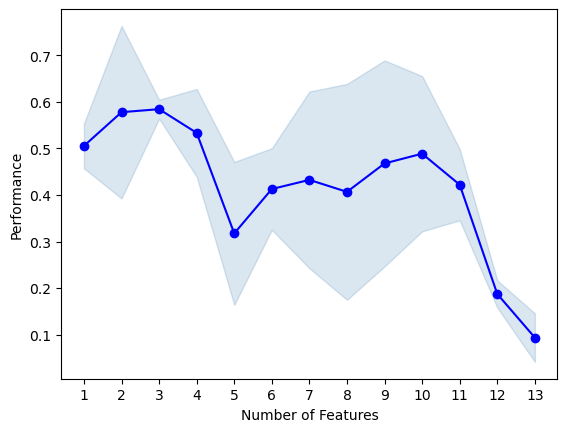

In [125]:
logReg = LogisticRegression(
    C=1e-6,
    class_weight="balanced",
    random_state=7,
    n_jobs=-1,
    max_iter=10000
)

sfs = SFS(
    logReg,
    k_features=(1,13),
    forward=True,
    floating=True,
    # scoring=make_scorer(auc_and_f1, needs_proba=True),
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
sfs.fit(X, y)
# print(sfs.k_score_)
print(sfs.k_feature_names_)
plot_sfs(sfs.get_metric_dict(), kind='std_dev')

df_final = df_sfs[list(sfs.k_feature_names_)]
df_final = pd.concat([df_sfs[["resp", "respPart"]], df_final], axis=1)

# Feature extraction

In [128]:
estimateScoresLogReg(df_final.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp", "respPart"], axis=1), y3)

X = df_final.drop(["VNSLC_16", "VNSLC_19"]).drop(["resp","respPart"], axis=1)
y = df_final["respPart"]

roc_auc + f1:	1.692	(0.900,	0.792)
accuracy:	0.796
LogLoss:	-1.099


#### PCA

/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

<AxesSubplot:>

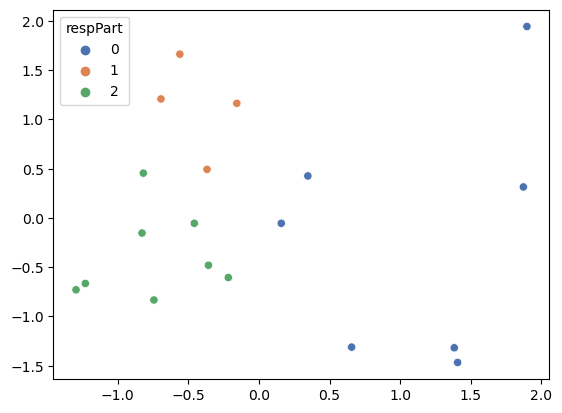

In [74]:
n_components = 2
whiten = True
pca = PCA(
    n_components,
    whiten=whiten,
    svd_solver="full",
    random_state=7
)

X_scaled = StandardScaler().fit_transform(X1)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y1, palette="deep")

#### LDA

/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/michele/anaconda3/envs/pyRadiomics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

<AxesSubplot:>

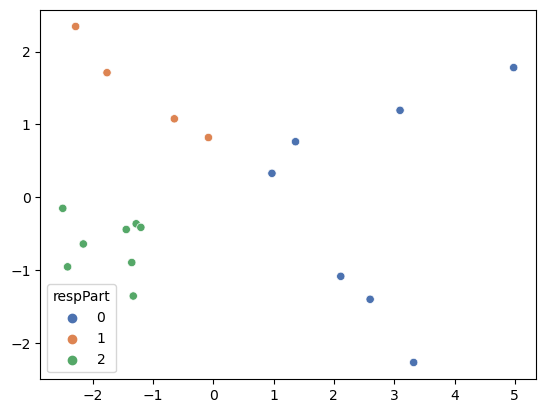

In [75]:
n_components = 2
# By using the Ledoit Wolf or OAS covariance mareices can be even better (Maybe see later)
lda = LinearDiscriminantAnalysis(
    # solver="eigen",
    # shrinkage="auto",
    n_components=n_components,
)

X_scaled = StandardScaler().fit_transform(X1)
X_lda = lda.fit_transform(X_scaled, y1)

sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=y1, palette="deep")